In [4]:
""" import data """
import pandas as pd

pd_train_origin_copy = pd.read_csv('data/train.csv').drop(columns=['diameter', 'albedo', 'diameter_sigma'])
pd_test_origin_copy = pd.read_csv('data/test.csv').drop(columns=['diameter', 'albedo', 'diameter_sigma'])
pd_train_origin_copy = pd_train_origin_copy.drop(columns = pd_train_origin_copy.columns[0])
pd_test_origin_copy = pd_test_origin_copy.drop(columns = pd_test_origin_copy.columns[0])
print(pd_train_origin_copy.columns.size)

/tmp/ipykernel_169000/2313469263.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_train_origin_copy = pd.read_csv('data/train.csv').drop(columns=['diameter', 'albedo', 'diameter_sigma'])
/tmp/ipykernel_169000/2313469263.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_test_origin_copy = pd.read_csv('data/test.csv').drop(columns=['diameter', 'albedo', 'diameter_sigma'])


43


In [6]:
""" Preparing for the knn model """

pd_train_origin = pd_train_origin_copy.copy()
pd_test_origin = pd_test_origin_copy.copy()

pd_train_corr = pd_train_origin.corr(numeric_only=True) # get a k*k matrix (k = the number of features)
corr_result = pd_train_corr['class_num']
#print(corr_result)
corr_idx = pd_train_corr['class_num'].index

ft = []
drop_ft = []
siz = corr_result.size

for i in range(siz):
    if((corr_result[i]) >= 0.27):
        ft.append(corr_idx[i])

for i in pd_train_origin.columns:
    if(i not in ft):
        drop_ft.append(i)
    else:
        pd_train_origin[i] = pd_train_origin[i].fillna(pd_train_origin[i].mean()) # Replace NaN values with the mean of the column
        pd_test_origin[i] = pd_test_origin[i].fillna(pd_test_origin[i].mean())

pd_train = pd_train_origin.drop(columns = drop_ft)
pd_test = pd_test_origin.drop(columns = drop_ft)

y_train = pd_train['class_num']
pd_train = pd_train.drop(columns = 'class_num')
y_test = pd_test['class_num']
pd_test = pd_test.drop(columns = 'class_num')

print(pd_train.columns)
print(pd_train.columns.size)

Index(['e', 'q', 'i', 'n', 'moid', 'moid_ld'], dtype='object')
6


In [7]:
""" modify the scalar and fitting """
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_sc = scaler.fit_transform(pd_train)
test_sc = scaler.transform(pd_test)

pca = PCA(n_components=4)
train_sc = pca.fit_transform(train_sc)
test_sc = pca.transform(test_sc)

print(train_sc.shape[1])

4


In [10]:
""" Training the knn model """
from sklearn.neighbors import KDTree
from collections import defaultdict
import numpy as np
from tqdm import tqdm

tree = KDTree(train_sc, leaf_size=30, metric='minkowski')

test_num = test_sc.shape[0]
pred = np.empty(test_num, dtype=train_sc.dtype)

k_num = 10

batch_size = 1000

for cur in tqdm(range(0, test_num, batch_size)):
    batch_end = min(cur+batch_size, test_num)
    distances, idx = tree.query(test_sc[cur:batch_end], k=k_num)

    for i in range(distances.shape[0]):
        weights = 1 / (distances[i] + 1e-7)
        label_weights = defaultdict(float)

        for j in range(k_num):
            label = y_train[idx[i][j]]
            label_weights[label] += weights[j]
        pred[cur+i] = max(label_weights, key=label_weights.get)


100%|██████████| 288/288 [00:10<00:00, 26.93it/s]


Accuracy :  0.997482238304058
Precision: 0.9974691655499829
Recall :  0.997482238304058
F1 Score :  0.9974618351894127


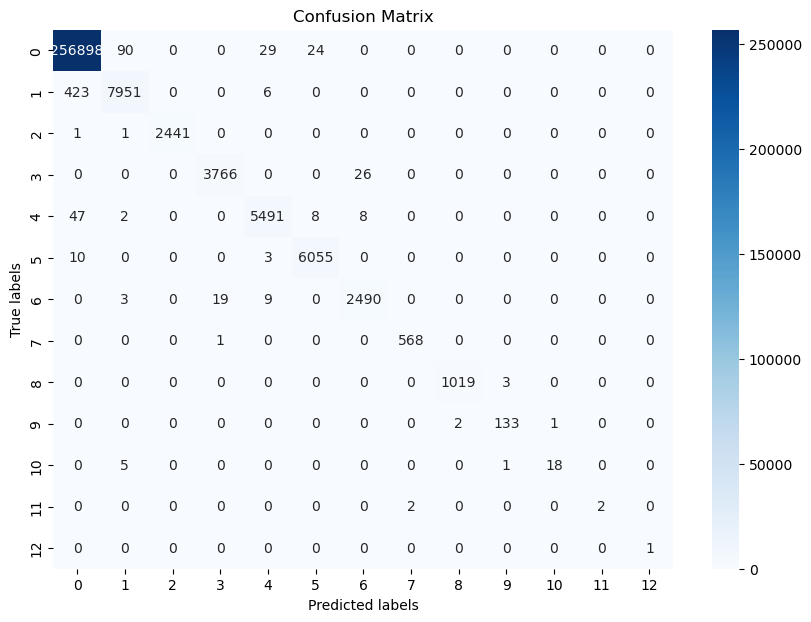

In [9]:
""" print the result """
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy : ", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred, average='weighted'))
print("Recall : ", recall_score(y_test, pred, average='weighted'))
print("F1 Score : ", f1_score(y_test, pred, average='weighted'))

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
""" export the result """

submission = pd.DataFrame({'IDX': pd_test.index.values,'Target': pred})
submission.to_csv('submission.csv', index=False)